# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself.

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [6]:
%matplotlib inline
import math, numpy as np, matplotlib.pyplot as plt
import operator

## Create data

In [7]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [8]:
centroids = np.random.uniform(-35., 35., (n_clusters, 2)) # dimension = 2, because each point is (x, y)
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples) 
          for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [9]:
def plot_data(centroids, data, n_samples):
    colour = plt.cm.rainbow(np.linspace(0, 1, len(centroids)))
    for i, centroid in enumerate(centroids):
        samples = data[n_samples*i: n_samples*(i+1)]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i], s=1)
        plt.plot(centroid[0], centroid[1], marker='x', markersize=10, color='k', mew=5)
        plt.plot(centroid[0], centroid[1], marker='x', markersize=5, color='r', mew=2)

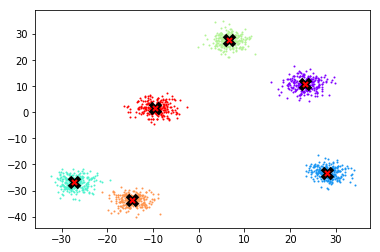

In [11]:
plot_data(centroids, data, n_samples)

## K means

The goal of clustering is to identify these clusters, defined by their centroids, given the raw data with no labels. Once these centroids have been identified, each point is labelled as belonging to the centroid it is closest to.

K means clustering is a simple and popular approach of finding appropriate centroids. It does this by taking random centroids, and iteratively moving them to make the clusters as compact as possible.

The algorithm is very simple:
- Select the number of clusters N you want to find
- Guess N random centroids (more on this below)
- While centroids change:
    - Create clusters by assigning each point to the nearest centroid
    - For each cluster, define the new centroid as the centroid of all points assigned to it
    
Typically the algorithm is terminated once the change in centroids is negligible or after a certain number of iterations.

While guessing random centroids is fine in theory, most implementations use the data itself to identify initial cluster points. This speeds up convergence by initializing centroids in the appropriate regime. Typically, inital points are selected amongst the data and tries to pick them to be as far apart as possible.

The result are centroids that have minimized the total distance between all points and their centroids; the centroids are "optimal" in this sense.

There are some problems with K-means clustering.
* Number of clusters needs to be known a priori
    * This is an obvious failure of an unsupervised learning algorithm; we want the data to "speak for itself"
    * Difficult to identify in higher dimensions
    
* Naive approach only works if the clusters are the same shape
    * This is because centroid is identified using euclidean distance

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
![Gaussian](http://images.books24x7.com/bookimages/id_5642/fig11-10.jpg)
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

So here's the definition of the gaussian kernel, which you may remember from high school...

In [12]:
def gaussion(d, bw): # bw: bandwidth = std (sigma)
    return 1/np.sqrt(2 * bw**2 * math.pi) * np.exp(- 1/2 * (d/bw)**2)
#    return 1/math.sqrt(2 * bw**2 * math.pi) * np.exp(- 1/2 * (d/bw)**2)

 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [94]:
# IMPORTANT numpy Broadcast tutorial

dat = data[:5]
print(dat.shape)
weight = np.ndarray([5])
print(weight.shape)

# Solution 1: This works after expanding dimension
weight_sol1 = np.expand_dims(weight, 1)
test_sol1 = weight_sol1 * dat
print(test_sol1.shape)

# Solution 2: This works after reshaping by (-1, 1)
weight_sol2 = weight.reshape(-1, 1)
test_sol2 = weight_sol2 * dat
print(test_sol2.shape)

# This fails when ndarray is in shape like (1500,)
test = weight * dat
print(test.shape)

(5, 2)
(5,)
(5, 2)
(5, 2)


ValueError: operands could not be broadcast together with shapes (5,) (5,2) 

In [13]:
def mean_shift(data):
    X = np.copy(data)
    for it in range(5):
        for i, x in enumerate(X):
            dist = np.sqrt(((x-X)**2).sum(1))
            weight = gaussion(dist, 2.5)
            X[i] = (np.expand_dims(weight,1) * X).sum(0) / weight.sum()
    return X

In [14]:
%time X = mean_shift(data)

Wall time: 1.52 s


We can see that mean shift clustering has almost reproduced our original clustering. The one exception are the very close clusters, but if we really wanted to differentiate them we could lower the bandwidth.

What is impressive is that this algorithm nearly reproduced the original clusters without telling it how many clusters there should be.

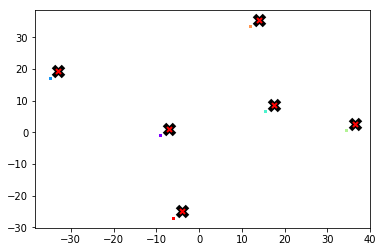

In [69]:
plot_data(centroids+2, X, n_samples)

We should be able to accelerate this algorithm with a GPU.

## Vectorization 
tried by Ted's own idea. mentioned by Andrew Ng Deep Learning course but not mentioned in Fast.ai course.
However the result seems only speeding up a little bit... maybe because data is too small?

In [102]:
def mean_shift(data):
    X = np.copy(data)
    for it in range(5):
        dist = np.sqrt(np.square(np.expand_dims(X, 1) - X).sum(-1))
        weight = gaussion(dist, 2.5)
        X = np.multiply(np.expand_dims(weight,-1), X).sum(1) / weight.sum(1).reshape(-1, 1)
    return X

In [103]:
%time X = mean_shift(data)

Wall time: 1.29 s


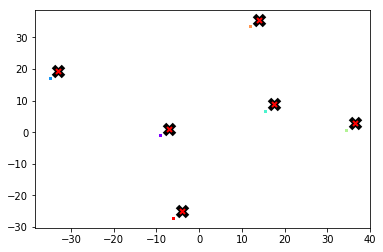

In [104]:
plot_data(centroids+2, X, n_samples)

### GPU

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [24]:
from importlib import reload
import torch_utils; reload(torch_utils)
from torch_utils import *

The advantage of pytorch is that it's very similar to numpy.

In [64]:
def gaussion(d, bw): # bw: bandwidth = std (sigma)
    return 1/math.sqrt(2 * bw**2 * math.pi) * torch.exp(- 1/2 * (d/bw)**2)

Torch does not support broadcasting, therefore Jeremy has replaced the distance subtraction line with a subtraction function from his custom pytorch broadcasting library.
### update: Torch support broadcasting already!!!

In [88]:
def mean_shift(data):
    X = torch.FloatTensor(data) #.cuda()
    for it in range(5):
        for i, x in enumerate(X):
            dist = torch.sqrt(((x-X)**2).sum(1))
            weight = gaussion(dist, 2.5)
            X[i] = (torch.unsqueeze(weight,1) * X).sum(0) / weight.sum()
    return X

In [89]:
%time X = mean_shift(data)

Wall time: 1.05 s


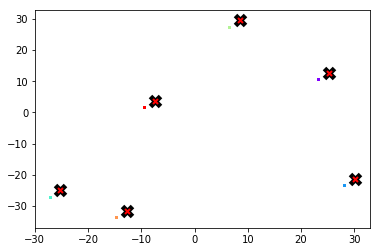

In [90]:
plot_data(centroids+2, X, n_samples)

## Vectorization on GPU
tried by Ted's own idea. mentioned by Andrew Ng Deep Learning course but not mentioned in Fast.ai course.**

### Great! Vectorization works well for Pytorch because of GPU optimization!

In [145]:
def mean_shift(data):
    X = torch.FloatTensor(data).cuda()
    for it in range(5):
        dist = torch.sqrt(torch.pow((torch.unsqueeze(X, 1) - X), 2).sum(-1))
        weight = gaussion(dist, 2.5)
        X = torch.mul(torch.unsqueeze(weight,-1), X).sum(1) / weight.sum(1).view(-1, 1)
    return X

In [146]:
%time X = mean_shift(data)

Wall time: 5.01 ms


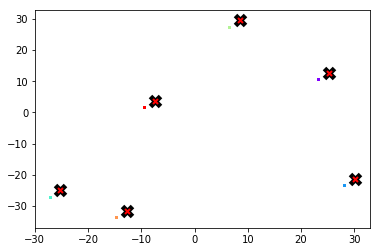

In [147]:
plot_data(centroids+2, X, n_samples)

In [140]:
%time X = mean_shift(data).cpu().numpy()

Wall time: 282 ms


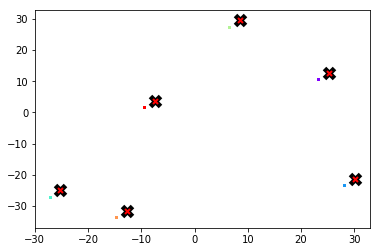

In [141]:
plot_data(centroids+2, X, n_samples)

#### Add batch size: slower but this can avoid long epoch

In [142]:
def mean_shift(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(data).cuda()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs, n))
            dist = torch.sqrt(torch.pow((torch.unsqueeze(X[s], 1) - X), 2).sum(-1))
            weight = gaussion(dist, 2.5)
            X[s] = torch.mul(torch.unsqueeze(weight,-1), X).sum(1) / weight.sum(1).view(-1, 1)
    return X

In [143]:
%time X = mean_shift(data).cpu().numpy()

Wall time: 288 ms


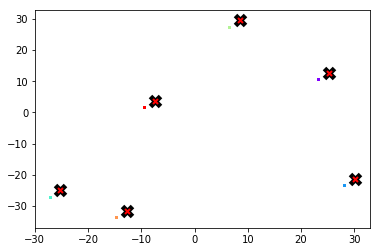

In [144]:
plot_data(centroids+2, X, n_samples)

### GPU

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [110]:
def dist_b(a, b):
    return torch.sqrt(torch.pow((a.unsqueeze(0) - b.unsqueeze(1)), 2).sum(2))
    #dist = torch.sqrt(torch.pow((torch.unsqueeze(X, 1) - X), 2).sum(-1))

In [113]:
a = torch.rand(2, 2)
b = torch.rand(3, 2)
dist_b(b, a)


 0.5172  0.4499  0.5142
 0.3962  0.4089  0.2220
[torch.FloatTensor of size 2x3]

In [114]:
def gaussion(d, bw): # bw: bandwidth = std (sigma)
    return 1/math.sqrt(2 * bw**2 * math.pi) * torch.exp(- 1/2 * (d/bw)**2)

In [123]:
def mean_shift(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(data).cuda()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(n, i+bs))
            dist = dist_b(X, X[s])
            weight = gaussion(dist, 2.5)
            X[s] = torch.mul(torch.unsqueeze(weight,-1), X).sum(1) / weight.sum(1).view(-1, 1)
            
    return X

In [124]:
%time X = mean_shift(data).cpu().numpy()

Wall time: 519 ms
